In [102]:
#  [1] Imports and Configuration
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import numpy as np
import random
from torchvision.transforms import functional as func
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [121]:
# Configuration
class Config:
    batch_size = 32
    num_epochs = 20
    lr = 1e-4
    num_source_domains = 5  # 0°, 30°, 60°
    source_domains = [0, 1] # amazon, webcam
    target_domain = [2]      # dslr
    num_classes = 31-1
    
config = Config()

In [105]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [106]:
root = "~/bhavyaaa/datasets/office31"  # change this

amazon = ImageFolder(f"{root}/amazon", transform=transform)
dslr = ImageFolder(f"{root}/dslr", transform=transform)
webcam = ImageFolder(f"{root}/webcam", transform=transform)

In [107]:
# Get full class list:
cls_to_idx = amazon.class_to_idx
all_classes = list(cls_to_idx.keys())
print("Classes in dataset:", all_classes)

# Last class = unseen
unseen_class = all_classes[-1]
unseen_idx = cls_to_idx[unseen_class]
print(f"Unseen class: {unseen_class}  (idx {unseen_idx})")

# Map: seen only
seen_classes = all_classes[:-1]
class_map_seen = {cls_to_idx[c]: i for i, c in enumerate(seen_classes)}
print("Seen class map:", class_map_seen)

config.num_classes = len(seen_classes)

Classes in dataset: ['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']
Unseen class: trash_can  (idx 30)
Seen class map: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29}


In [108]:
# Make split indices
amazon_seen = [i for i, (_, y) in enumerate(amazon.samples) if y != unseen_idx]
webcam_seen = [i for i, (_, y) in enumerate(webcam.samples) if y != unseen_idx]
dslr_seen = [i for i, (_, y) in enumerate(dslr.samples) if y != unseen_idx]

amazon_unseen = [i for i, (_, y) in enumerate(amazon.samples) if y == unseen_idx]
webcam_unseen = [i for i, (_, y) in enumerate(webcam.samples) if y == unseen_idx]
dslr_unseen = [i for i, (_, y) in enumerate(dslr.samples) if y == unseen_idx]


In [109]:
class Office31DomainRemap(Dataset):
    def __init__(self, base, domain_label, class_map):
        self.base = base
        self.domain_label = domain_label
        self.class_map = class_map

    def __getitem__(self, index):
        img, label = self.base[index]
        if label not in self.class_map:
            raise ValueError(f"Label {label} not in map!")
        new_label = self.class_map[label]
        return img, new_label, self.domain_label

    def __len__(self):
        return len(self.base)


In [110]:
# Training = seen classes, source domains
train_dataset = ConcatDataset([
    Office31DomainRemap(Subset(amazon, amazon_seen), 0, class_map_seen),
    Office31DomainRemap(Subset(webcam, webcam_seen), 1, class_map_seen)
])

# Testing = seen classes, target domain (dslr)
test_dataset = Office31DomainRemap(Subset(dslr, dslr_seen), 2, class_map_seen)


In [111]:
# Unseen = unseen class only, target domain
# (Keep same label index for unseen, so no remap)
class Office31Unseen(Dataset):
    def __init__(self, base, domain_label, unseen_label_idx):
        self.base = base
        self.domain_label = domain_label
        self.unseen_label_idx = unseen_label_idx

    def __getitem__(self, index):
        img, label = self.base[index]
        assert label == self.unseen_label_idx
        return img, 0, self.domain_label  # You can label unseen as 0 for novelty

    def __len__(self):
        return len(self.base)

unseen_test_dataset = Office31Unseen(Subset(dslr, dslr_unseen), 2, unseen_idx)

In [112]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=4)
unseen_test_loader = DataLoader(unseen_test_dataset, batch_size=config.batch_size, num_workers=4)


In [113]:
#  [4] Model Architecture (Domain-Adversarial + Evidential)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet50(pretrained=True)
        modules = list(backbone.children())[:-1]  # remove fc
        self.backbone = nn.Sequential(*modules)
        self.out_dim = backbone.fc.in_features

    def forward(self, x):
        x = self.backbone(x)
        return x.view(x.size(0), -1)

class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

class DomainClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.grl = GradientReversal.apply
        self.net = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(),
            nn.Linear(512, len(config.source_domains))
        )

    def forward(self, x, alpha=1.0):
        x = self.grl(x, alpha)
        return self.net(x)

class EvidentialHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2048, config.num_classes)

    def forward(self, x):
        evidence = torch.relu(self.fc(x))  # Use ReLU, not exp
        alpha = evidence + 1.0             # Dirichlet prior
        return alpha

In [114]:
def fixed_mixup(x1, x2, y1, y2, d1, d2):
    if y1 == y2 and d1 != d2:
        lam = np.random.beta(0.4, 0.4)
        return lam * x1 + (1 - lam) * x2, y1
    return None

In [115]:
class EvidentialLoss(nn.Module):
    def __init__(self, coeff=1.0, kl_coeff=0.1):
        super().__init__()
        self.coeff = coeff
        self.kl_coeff = kl_coeff

    def forward(self, alpha, targets):
        S = torch.sum(alpha, dim=1, keepdim=True)
        p = alpha / S

        # 1) Negative log likelihood
        ce_loss = -torch.sum(targets * torch.log(p), dim=1)

        # 2) Evidence mismatch penalty
        error = (targets - p) ** 2
        var = p * (1 - p) / (S + 1)
        mse_loss = torch.sum(error + var, dim=1)

        # KL divergence with Dirichlet prior (1,...,1)
        kl = self.kl_divergence(alpha)

        total_loss = ce_loss + self.coeff * mse_loss + self.kl_coeff * kl
        return total_loss.mean()

    def kl_divergence(self, alpha):
        K = alpha.size(1)
        beta = torch.ones((1, K)).to(alpha.device)
        S_alpha = torch.sum(alpha, dim=1, keepdim=True)
        S_beta = torch.sum(beta, dim=1, keepdim=True)

        lnB = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alpha), dim=1, keepdim=True)
        lnB_uni = torch.sum(torch.lgamma(beta), dim=1, keepdim=True) - torch.lgamma(S_beta)

        dg0 = torch.digamma(S_alpha)
        dg1 = torch.digamma(alpha)

        kl = torch.sum((alpha - beta) * (dg1 - dg0), dim=1, keepdim=True) + lnB + lnB_uni
        return kl.squeeze()


In [116]:
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor = FeatureExtractor().to(device)
    domain_classifier = DomainClassifier().to(device)
    evidential_head = EvidentialHead().to(device)

    optimizer = torch.optim.Adam(
        list(feature_extractor.parameters()) +
        list(domain_classifier.parameters()) +
        list(evidential_head.parameters()),
        lr=config.lr
    )

    criterion = EvidentialLoss(coeff=1.0, kl_coeff=0.1)

    for epoch in range(config.num_epochs):
        feature_extractor.train()
        domain_classifier.train()
        evidential_head.train()

        for images, labels, domains in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            domains = domains.to(device)

            features = feature_extractor(images)

            # Domain classifier with gradient reversal
            p = epoch / config.num_epochs
            grl_alpha = 2 / (1 + np.exp(-10 * p)) - 1
            domain_preds = domain_classifier(features, alpha=grl_alpha)
            domain_loss = nn.CrossEntropyLoss()(domain_preds, domains)

            # Mixup: only if different domain same class
            mixed_features = []
            mixed_labels = []
            for i in range(0, len(images)-1, 2):
                mix_result = fixed_mixup(
                    features[i], features[i+1],
                    labels[i], labels[i+1],
                    domains[i], domains[i+1]
                )
                if mix_result:
                    mixed_x, mixed_y, _ = mix_result
                    mixed_features.append(mixed_x)
                    mixed_labels.append(mixed_y)

            # Pure evidential loss
            pure_alpha = evidential_head(features)
            pure_labels_onehot = nn.functional.one_hot(labels, config.num_classes).float().to(device)
            pure_loss = criterion(pure_alpha, pure_labels_onehot)

            # Mixed loss
            if mixed_features:
                mixed_features = torch.stack(mixed_features)
                mixed_labels = torch.tensor(mixed_labels, dtype=torch.long).to(device)
                mixed_alpha = evidential_head(mixed_features)
                mixed_labels_onehot = nn.functional.one_hot(mixed_labels, config.num_classes).float().to(device)
                mixed_loss = criterion(mixed_alpha, mixed_labels_onehot)
            else:
                mixed_loss = 0

            evidential_loss = pure_loss + mixed_loss
            total_loss = evidential_loss + 0.5 * domain_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{config.num_epochs} | "
              f"Total Loss: {total_loss.item():.4f} | "
              f"Evidential Loss: {evidential_loss.item():.4f} | "
              f"Domain Loss: {domain_loss.item():.4f}")

    return feature_extractor, evidential_head


In [117]:
# print("config.num_classes =", config.num_classes)

# # Look at actual unique labels in train set:
# all_labels = []
# for _, label, _ in train_loader.dataset:
#     all_labels.append(label)
# print("Unique labels in train:", sorted(set(all_labels)))

In [118]:
# domain_labels = []
# for _, _, dom in train_loader.dataset:
#     domain_labels.append(dom)
# print("Unique domain labels:", sorted(set(domain_labels)))
# print("config.source_domains =", config.source_domains)
# print("num domain outputs =", len(config.source_domains))

In [122]:
# CUDA_LAUNCH_BLOCKING=1
feature_extractor, evidential_head = train_model()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [20]:
#  [8] Evaluation Metrics (From [3] and [5] concepts)
def seen_evaluate(feature_extractor, evidential_head, loader):
    feature_extractor.eval()
    evidential_head.eval()

    correct = 0
    total = 0
    uncertainties = []
    all_preds = []
    all_labels = []
    correct_uncertainties = []
    incorrect_uncertainties = []

    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)

            features = feature_extractor(images)
            alpha = evidential_head(features)

            # Predictions
            preds = torch.argmax(alpha, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            # Uncertainty (total evidence)
            S = torch.sum(alpha, dim=1)
            sample_uncertainty = (config.num_classes / S).cpu().tolist()
            uncertainties.extend(sample_uncertainty)

            # Split by correctness
            correct_mask = (preds == labels)
            for u, is_correct in zip(sample_uncertainty, correct_mask.cpu()):
                if is_correct:
                    correct_uncertainties.append(u)
                else:
                    incorrect_uncertainties.append(u)

            correct += correct_mask.sum().item()
            total += len(labels)

    cm = confusion_matrix(all_labels, all_preds)
    acc = correct / total
    avg_uncertainty = np.mean(uncertainties)
    print(f"Test Accuracy: {acc*100:.2f}% | Avg Uncertainty: {avg_uncertainty:.4f}")

    return acc, avg_uncertainty, cm, correct_uncertainties, incorrect_uncertainties

In [21]:
#  [8] Evaluation Metrics (From [3] and [5] concepts)
def unseen_evaluate(feature_extractor, evidential_head, loader):
    feature_extractor.eval()
    evidential_head.eval()

    uncertainties = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, _, _ in loader:
            images = images.to(device)
            features = feature_extractor(images)
            alpha = evidential_head(features)

            # Predictions
            preds = torch.argmax(alpha, dim=1)
            all_preds.extend(preds.cpu().tolist())

            # Uncertainty (total evidence)
            S = torch.sum(alpha, dim=1)
            sample_uncertainty = (config.num_classes / S).cpu().tolist()
            uncertainties.extend(sample_uncertainty)

    avg_uncertainty = np.mean(uncertainties)
    print(f"Avg Uncertainty: {avg_uncertainty:.4f}")

   # ---- Combined Figure ----
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # 2️⃣ Histogram: correct
    axes[0].hist(uncertainties, bins=30, alpha=0.7, color='green')
    axes[0].set_title("Uncertainties")
    axes[0].set_xlabel("Uncertainty")
    axes[0].set_ylabel("Count")

    # 3️⃣ Histogram: incorrect
    axes[1].hist(all_preds, bins=config.num_classes, alpha=0.7, color='red')
    axes[1].set_title("Predictions")
    axes[1].set_xlabel("Labels")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

Test Accuracy: 54.95% | Avg Uncertainty: 0.8364


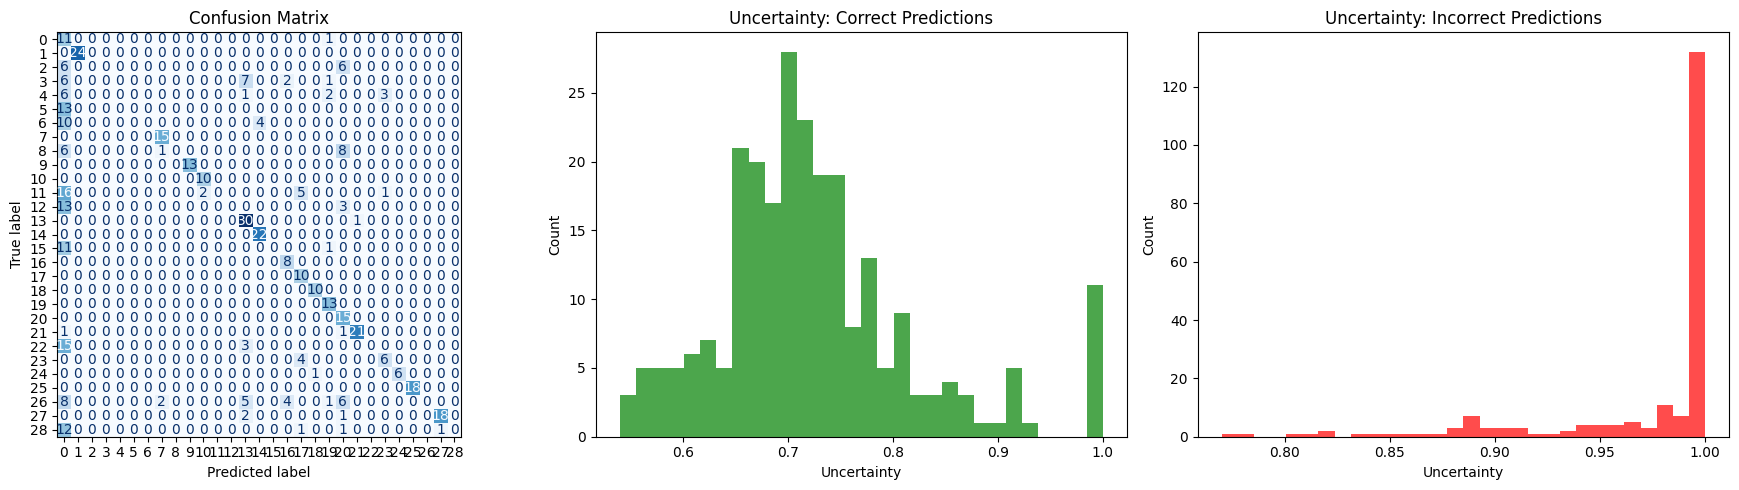

In [22]:
acc, avg_uncertainty, cm, correct_uncertainties, incorrect_uncertainties = seen_evaluate(feature_extractor, evidential_head, test_loader)

# ---- Combined Figure ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1️⃣ Confusion Matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Confusion Matrix")

# 2️⃣ Histogram: correct
axes[1].hist(correct_uncertainties, bins=30, alpha=0.7, color='green')
axes[1].set_title("Uncertainty: Correct Predictions")
axes[1].set_xlabel("Uncertainty")
axes[1].set_ylabel("Count")

# 3️⃣ Histogram: incorrect
axes[2].hist(incorrect_uncertainties, bins=30, alpha=0.7, color='red')
axes[2].set_title("Uncertainty: Incorrect Predictions")
axes[2].set_xlabel("Uncertainty")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

Avg Uncertainty: 0.9636


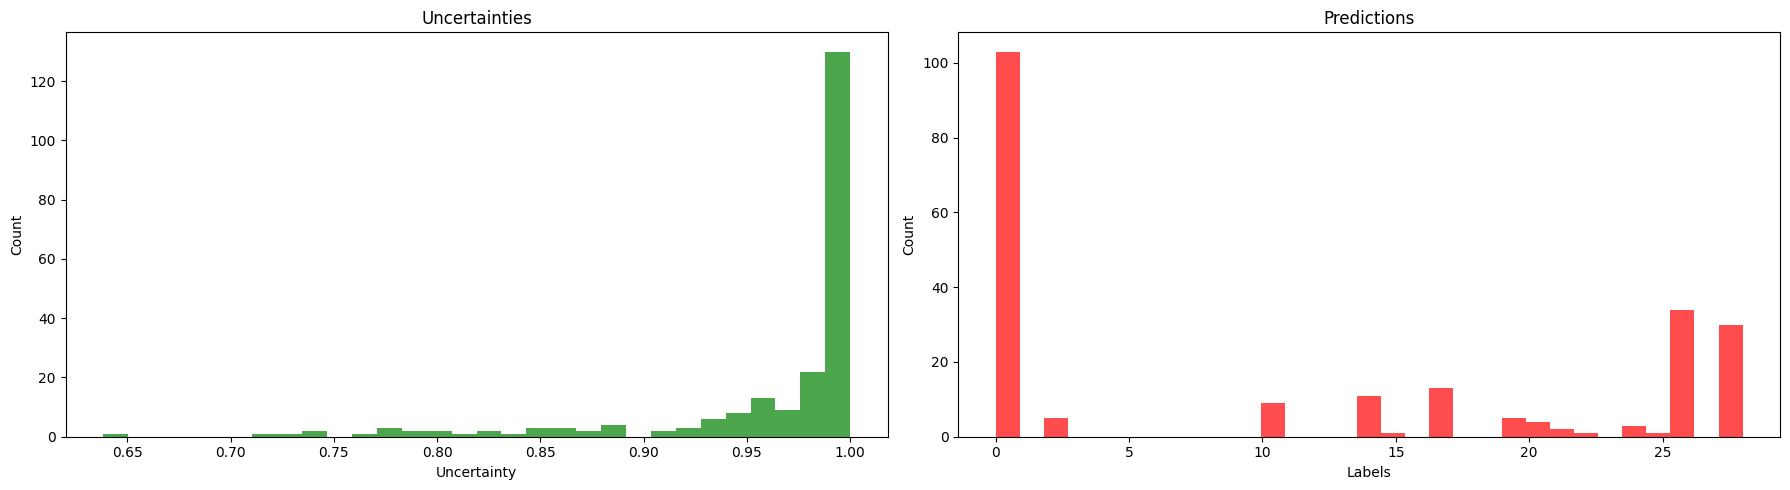

In [23]:
unseen_evaluate(feature_extractor, evidential_head, unseen_train_loader)

Avg Uncertainty: 0.9668


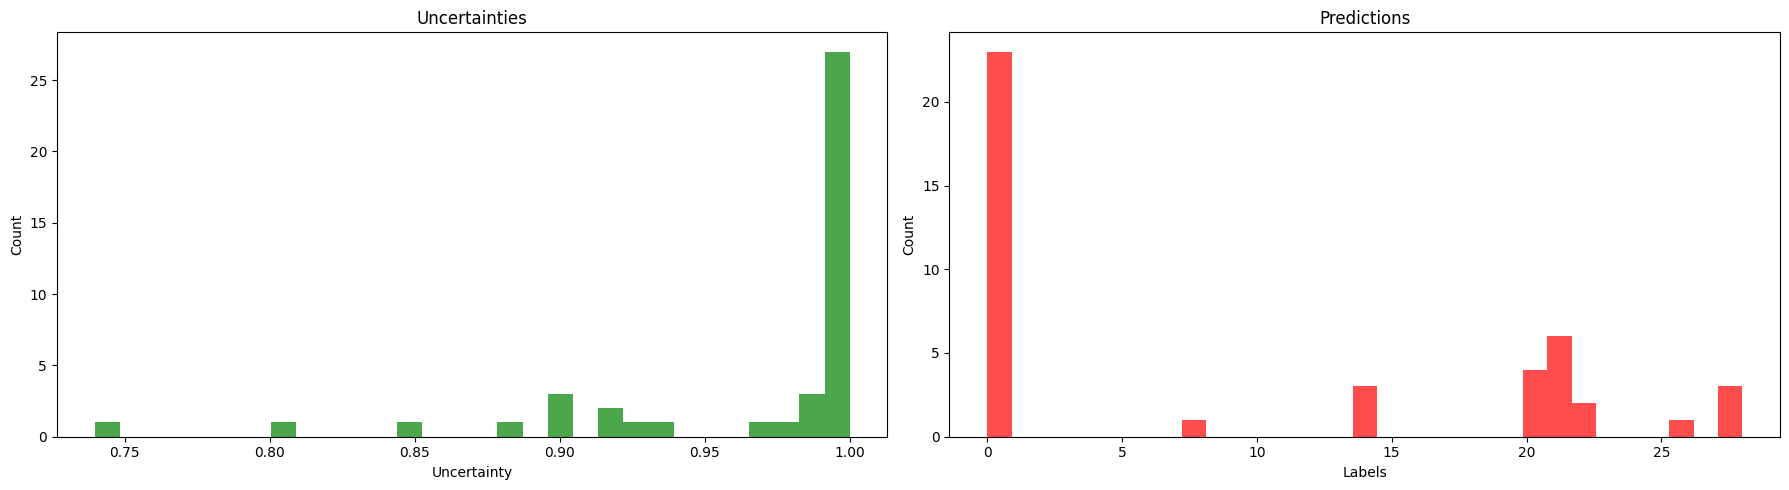

In [24]:
unseen_evaluate(feature_extractor, evidential_head, unseen_test_loader)